# **Task 2: Recommend 10 Similar Furniture Items Based on Input Image**

Task 2 involves recommending 10 furniture items from our dataset that are similar to the input furniture item image provided by users. In order to achieve this, we need to define a metric of "similarity" between two furniture items. This task requires building a recommendation system that utilizes the defined similarity metric to find and display the most similar furniture items.


## Loading Required Libraries

In this section, we will mount Google Drive to access the dataset and install the necessary libraries, such as TensorFlow, for our deep learning tasks.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install tensorflow

In [3]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
import numpy as np
from google.colab import files
from IPython.display import Image, display
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

## Step 1: Define Data Directory and Categories

In this cell, we define the directory path where our furniture data is stored and specify the categories and interior styles of the furniture items. The `data_dir` variable holds the path to the dataset, while `categories` and `interior_styles` are lists containing different types of furniture and their respective styles that will be used in our model.


In [4]:
data_dir = '/content/drive/MyDrive/Furniture_Dataa'
categories = ['beds', 'chairs', 'dressers', 'lamps', 'sofas', 'tables']
interior_styles = ['Asian', 'Beach', 'Contemporary', 'Craftsman', 'Eclectic', 'Farmhouse',
                   'Industrial', 'Mediterranean', 'Midcentury', 'Modern', 'Rustic', 'Scandinavian',
                   'Southwestern', 'Traditional', 'Transitional', 'Tropical', 'Victorian']

## Step 2: Load Images and Labels from Directory

This function `load_images(data_dir)` is responsible for loading the images, their corresponding category labels, and style labels from the specified directory. It iterates through each category and style subdirectory, processes the images, and stores them in separate lists. These lists are then converted into numpy arrays and returned for further processing.


In [5]:
def load_images(data_dir):
    images = []  # List to store image arrays
    labels = []  # List to store category labels
    styles = []  # List to store style labels

    # Iterate over each category in categories
    for category in categories:
        category_dir = os.path.join(data_dir, category)  # Path to the category directory

        # Iterate over each style in interior_styles
        for style in interior_styles:
            style_dir = os.path.join(category_dir, style)  # Path to the style directory

            # Skip if the style directory does not exist
            if not os.path.exists(style_dir):
                continue

            # Iterate over each file in the style directory
            for filename in os.listdir(style_dir):
                img = load_img(os.path.join(style_dir, filename), target_size=(224, 224))  # Load and resize the image
                img_array = img_to_array(img)  # Convert the image to an array

                img_array = img_array / 255.0  # Normalize the image array
                images.append(img_array)  # Append the image array to images list
                labels.append(categories.index(category))  # Append the category index to labels list
                styles.append(interior_styles.index(style))  # Append the style index to styles list

    return np.array(images), np.array(labels), np.array(styles)  # Return the images, labels, and styles as numpy arrays


### Load Images and Extract Labels and Styles


In [6]:
images, labels, styles = load_images(data_dir)


### Splitting Data into Training and Testing Sets

In this cell, we split the loaded images, labels, and styles into training and testing sets. The `train_test_split` function from `sklearn.model_selection` is used with a test size of 20% and a random state of 42 to ensure reproducibility.


In [7]:

X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(images, labels, styles, test_size=0.2, random_state=42)

## Step 3: Build and Train Style Classification Model

This section defines and trains a CNN model to classify the style of furniture items. The model includes several convolutional layers followed by max-pooling layers, a dense layer, and a dropout layer. The model is compiled with Adam optimizer and sparse categorical cross-entropy loss. The training process uses a validation split of 20%.


In [8]:
def build_style_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # First convolutional layer with max pooling layer
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),  # Second convolutional layer with max pooling layer
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),  # Third convolutional layer with max pooling layer
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),  # Fourth convolutional layer with max pooling layer
        MaxPooling2D((2, 2)),
        Flatten(),  # Flatten the output for the dense layers
        Dense(512, activation='relu'),  # Fully connected layer with ReLU activation
        Dropout(0.5),  # Dropout layer for regularization
        Dense(len(categories), activation='softmax')  # Output layer with softmax activation
    ])
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Compile the model
    return model

style_model = build_style_model()
style_model.summary()  # Print the model summary

# Train the model with the training data, using a validation split and specified epochs and batch size
history = style_model.fit(X_train, y_train, epochs=15, validation_split=0.2, batch_size=70)

# Evaluate the model on the test data
test_loss, test_accuracy = style_model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy:.4f}')

# Print out the accuracy for each epoch
for epoch, accuracy in enumerate(history.history['accuracy'], start=1):
    print(f'Epoch {epoch}: accuracy {accuracy:.4f}')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

### Extracting Features and Recommending Similar Items

In this section, we define functions to extract features from images using a trained model and to recommend similar items based on a given input image.

1. **Extract Features with Generator:**
    - The function `extract_features_with_generator` uses an `ImageDataGenerator` to process the image data in batches.
    - It takes a model, image data, and batch size as input and returns the features extracted by the model.

2. **Create Feature Extractor:**
    - We create a feature extractor model that outputs the features from the penultimate layer of the style model.

3. **Extract Features:**
    - We use the `extract_features_with_generator` function to extract features from the entire image dataset.

4. **Recommend Similar Items:**
    - The function `recommend_similar_items` takes an input image, the extracted features, and the number of top recommendations to return.
    - It predicts the features of the input image, calculates cosine similarities with the dataset features, and returns the indices of the most similar items.


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def extract_features_with_generator(model, data, batch_size=32):
    datagen = ImageDataGenerator()
    generator = datagen.flow(data, batch_size=batch_size, shuffle=False)
    features = model.predict(generator, steps=np.ceil(len(data) / batch_size))
    return features


feature_extractor = Model(inputs=style_model.input, outputs=style_model.layers[-2].output)


features = extract_features_with_generator(feature_extractor, images, batch_size=32)

def recommend_similar_items(input_image, features, top_n=10):
    input_features = feature_extractor.predict(np.expand_dims(input_image, axis=0))
    similarities = cosine_similarity(input_features, features)
    similar_indices = similarities.argsort()[0][-top_n-1:-1][::-1]
    return similar_indices




134/134 [==============================] - 4s 28ms/step


## Step 4: Function to Upload an Image and Recommend Similar Items

In this section, we define two functions:

1. **Display Images:**
    - The function `display_images` takes a list of indices and displays the corresponding images in a grid.
    - It sets the figure size and uses `plt.subplot` to arrange the images in a 2x5 grid.
    - Each image is shown using `plt.imshow`, and the axis is turned off for a cleaner display.

2. **Upload and Recommend:**
    - The function `upload_and_recommend` allows the user to upload an image.
    - It loads the uploaded image, normalizes it, and converts it to an array.
    - The function then calls `recommend_similar_items` to get the indices of similar items based on the uploaded image.
    - Finally, it displays the recommended images using the `display_images` function.

Saving 5479asian-table-lamps.jpg to 5479asian-table-lamps.jpg
1/1 [==============================] - 0s 295ms/step


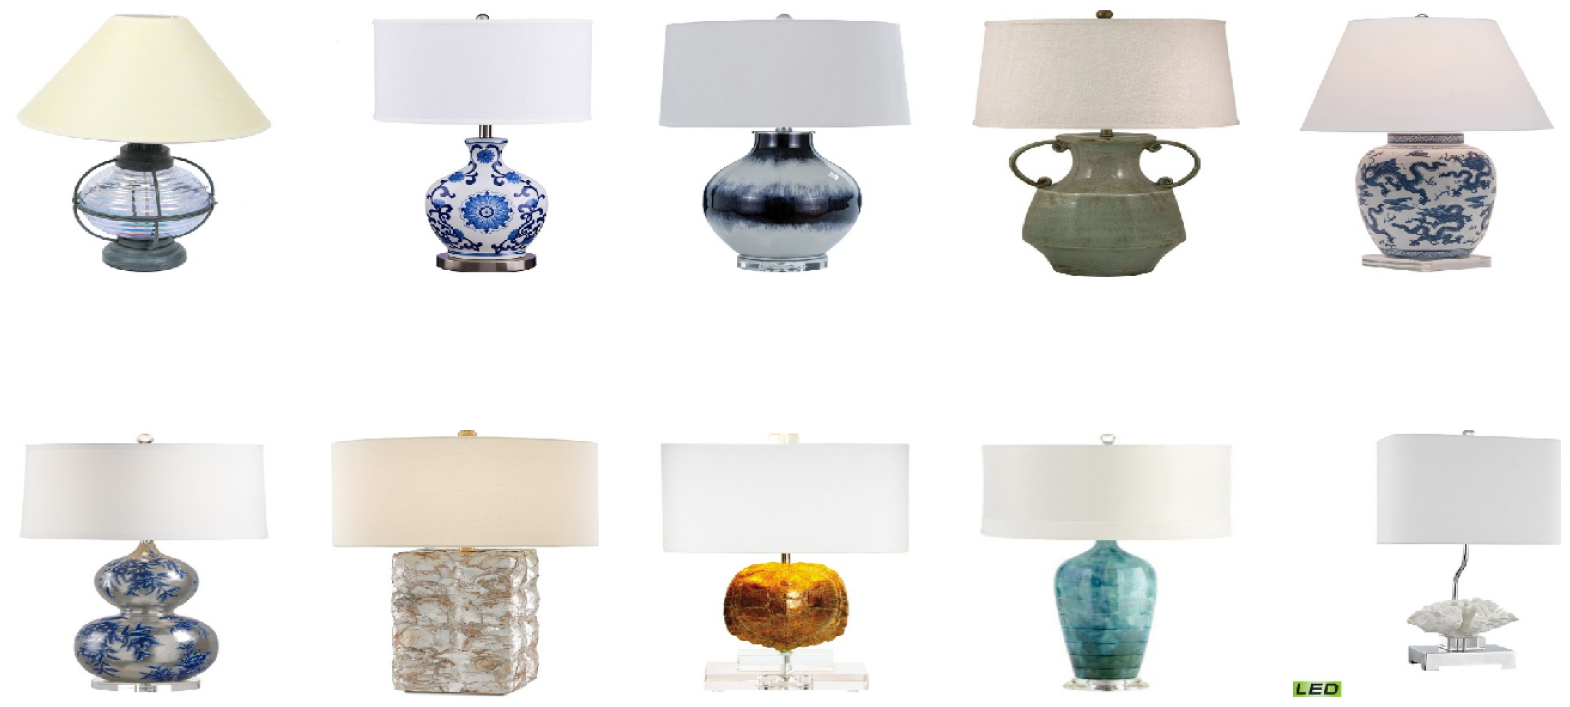

In [10]:

def display_images(indices):
    plt.figure(figsize=(20, 10))
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[idx])
        plt.axis('off')
    plt.show()


def upload_and_recommend():
    uploaded = files.upload()
    for fn in uploaded.keys():
        img_path = fn
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0  # Normalize
        similar_indices = recommend_similar_items(img_array, features)
        display_images(similar_indices)

upload_and_recommend()



*****************************************